# _(Diesmann, et, al., 1999)_ Synfire Chains

Implementation of the paper:

- Diesmann, Markus, Marc-Oliver Gewaltig, and Ad Aertsen. "Stable propagation of synchronous spiking in cortical neural networks." Nature 402.6761 (1999): 529-533.

In [1]:
import numpy as np
import brainpy as bp

bp.profile.set(jit=True)

In [2]:
duration = 100.  # ms

# Neuron model parameters
Vr = -70.  # mV
Vt = -55.  # mV
tau_m = 10.  # ms
tau_ref = 1.  # ms
tau_psp = 0.325  # ms
weight = 4.86  # mV
noise = 39.24  # mV

# Neuron groups
n_groups = 10
group_size = 100
spike_sigma = 1.

# Synapse parameter
delay = 5.0  # ms

In [3]:
# neuron model
# ------------


class Groups(bp.NeuGroup):
    def __init__(self, num):
        @bp.integrate
        def int_V(V, t, x):
            return (-(V - Vr) + x) / tau_m

        @bp.integrate
        def int_x(x, t, y):
            return (-x + y) / tau_psp

        @bp.integrate
        def int_y(y, t):
            df = -y / tau_psp + 25.27
            dg = noise
            return df, dg

        def neu_update(ST, _t, ):
            ST['x'] = int_x(ST['x'], _t, ST['y'])
            ST['y'] = int_y(ST['y'], _t)
            ST['spike'] = 0.
            ST['not_ref'] = 0.
            if _t - ST['t_last_spike'] >= tau_ref:
                V = int_V(ST['V'], _t, ST['x'])
                if V > Vt:
                    ST['spike'] = 1.
                    ST['t_last_spike'] = _t
                    ST['V'] = Vr
                else:
                    ST['V'] = V
                    ST['not_ref'] = 1.

        neu_state = bp.NeuState('V', 'x', 'y', 'spike', 'not_ref', t_last_spike=-1e7)

        neuron = bp.NeuType(name='neuron', ST=neu_state, steps=neu_update, mode='scalar')

        super(Groups, self).__init__(model=neuron, geometry=num, monitors=['spike'])

        self.ST['V'] = Vr + np.random.random(num) * (Vt - Vr)

In [4]:
# synaptic  model
# ---------------

class SynBetweenGroups(bp.SynConn):
    def __init__(self, group, ext_group):
        # step 1: define the all2all connectivity
        mat1 = np.ones((ext_group.num, group_size))
        mat2 = np.ones((group_size, group_size))

        # step 2: define the synaptic computation logic

        def update(ST, pre, ext):
            # synapse model between external and group 1
            end = group_size
            ST['g'][:end] = weight * np.dot(ext['spike'], mat1)

            # feed-forward connection
            for i in range(1, n_groups):
                s1 = (i - 1) * group_size
                s2 = i * group_size
                s3 = (i + 1) * group_size
                ST['g'][s2: s3] = weight * np.dot(pre['spike'][s1: s2], mat2)

        @bp.delayed
        def output(ST, post):
            post['y'] += ST['g']

        model = bp.SynType(name='syn', ST=bp.SynState('g'), steps=(update, output))

        # step 3: initialize the synaptic connection
        super(SynBetweenGroups, self).__init__(model=model,
                                               # SynConn needs "num" to initialize
                                               satisfies={'num': group.num},
                                               delay=delay)

        # step 4: assign the needed data
        self.pre = group.ST
        self.post = group.ST
        self.ext = ext_group.ST

In [7]:
# network running
# ---------------

def run_network(spike_num=48):
    ext_group = bp.inputs.SpikeTimeInput(spike_num,
                                         times=np.random.randn(spike_num) * spike_sigma + 20,
                                         indices=np.arange(spike_num))
    group = Groups(num=n_groups * group_size)
    syn_conn = SynBetweenGroups(group, ext_group)

    net = bp.Network(group, ext_group, syn_conn)
    net.run(duration, report=True)

    bp.visualize.raster_plot(net.ts, group.mon.spike, xlim=(0, duration), show=True)


When external spike num is 51, there exists "synfire chain".

Compilation used 1.0042 s.
Start running ...
Run 10.0% used 0.005 s.
Run 20.0% used 0.010 s.
Run 30.0% used 0.016 s.
Run 40.0% used 0.021 s.
Run 50.0% used 0.026 s.
Run 60.0% used 0.032 s.
Run 70.0% used 0.037 s.
Run 80.0% used 0.042 s.
Run 90.0% used 0.047 s.
Run 100.0% used 0.052 s.
Simulation is done in 0.052 s.


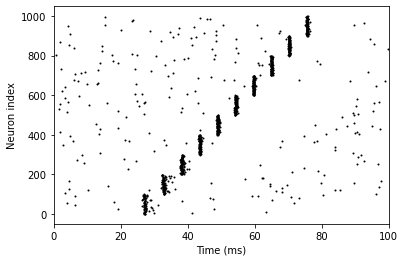

In [8]:
run_network(spike_num=51)

When external spike num is 46, the synchronous excitation disperses and eventually dies out.

Compilation used 0.9363 s.
Start running ...
Run 10.0% used 0.005 s.
Run 20.0% used 0.009 s.
Run 30.0% used 0.014 s.
Run 40.0% used 0.019 s.
Run 50.0% used 0.024 s.
Run 60.0% used 0.029 s.
Run 70.0% used 0.034 s.
Run 80.0% used 0.038 s.
Run 90.0% used 0.043 s.
Run 100.0% used 0.048 s.
Simulation is done in 0.048 s.


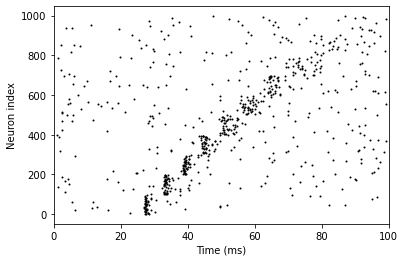

In [9]:
run_network(spike_num=46)